In [ ]:
import pandas as pd

df = pd.read_csv("train.csv")
X = df.drop(columns=["RiskScore"])


# Нормализация

In [ ]:
import numpy as np

def z_score_normalization(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    stds[stds == 0] = 1e-8

    normalized_X = (X - means) / stds
    return normalized_X, means, stds


In [ ]:
def min_max_normalization(X, new_min=0, new_max=1):
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)

    range_values = maxs - mins
    range_values[range_values == 0] = 1e-8

    normalized_X = (X - mins) / range_values
    normalized_X = normalized_X * (new_max - new_min) + new_min
    return normalized_X, mins, maxs


In [ ]:
X_numeric = X.select_dtypes(include=[np.number])

X_zscore, z_means, z_stds = z_score_normalization(X_numeric.values)
X_minmax, x_mins, x_maxs = min_max_normalization(X_numeric.values)

# линейная регрессия

In [ ]:
import numpy as np

class LinearRegressionModel:
    def __init__(self):
        self.weights = None

    def add_bias(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    def fit_analytic(self, X, y):
        X_b = self.add_bias(X)
        # w = (X^T X)^-1 X^T y
        self.weights = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

    def fit_gd(self, X, y, learning_rate=0.01, epochs=1000):
        X_b = self.add_bias(X)
        n_samples, n_features = X_b.shape
        self.weights = np.zeros(n_features)

        for _ in range(epochs):
            y_pred = X_b @ self.weights
            gradient = 2 / n_samples * X_b.T @ (y_pred - y)
            self.weights -= learning_rate * gradient

    def fit_sgd(self, X, y, learning_rate=0.01, epochs=1000):
        X_b = self.add_bias(X)
        n_samples, n_features = X_b.shape
        self.weights = np.zeros(n_features)

        for epoch in range(epochs):
            for i in range(n_samples):
                xi = X_b[i, :].reshape(1, -1)
                yi = y[i]
                yi_pred = xi @ self.weights
                gradient = 2 * xi.T @ (yi_pred - yi)
                self.weights -= learning_rate * gradient.flatten()

    def predict(self, X):
        X_b = self.add_bias(X)
        return X_b @ self.weights

    def fit(self, X, y, method="analytical", learning_rate=0.01, epochs=1000):
        if method == "analytical":
            self.fit_analytic(X, y)
        elif method == "gradient":
            self.fit_gd(X, y, learning_rate=learning_rate, epochs=epochs)
        elif method == "stochastic":
            self.fit_sgd(X, y, learning_rate=learning_rate, epochs=epochs)
        else:
            raise ValueError(f"Unknown fit method: {method}")


# Метрики

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv')

print(df.isna().sum() / len(df) * 100)

print(df.info())

pd.set_option('display.max_columns', None)

print(df.describe())


ApplicationDate               4.810747
Age                           4.810747
AnnualIncome                  4.810747
CreditScore                   9.358265
LoanAmount                    9.358265
LoanDuration                  4.810747
MaritalStatus                 4.810747
NumberOfDependents            4.810747
HomeOwnershipStatus           4.810747
MonthlyDebtPayments           9.358265
CreditCardUtilizationRate     4.810747
NumberOfOpenCreditLines       4.810747
NumberOfCreditInquiries       4.810747
DebtToIncomeRatio             4.810747
BankruptcyHistory             9.358265
LoanPurpose                   9.358265
PreviousLoanDefaults          4.810747
PaymentHistory                4.810747
LengthOfCreditHistory         4.810747
SavingsAccountBalance         4.810747
CheckingAccountBalance        9.358265
TotalAssets                   9.358265
TotalLiabilities              4.810747
MonthlyIncome                 4.810747
UtilityBillsPaymentHistory    4.810747
JobTenure                

In [ ]:
df = df.drop(columns=['ApplicationDate'], errors='ignore')

numeric_features = df.select_dtypes(include="number").columns
categorical_features = df.select_dtypes(include="object").columns

df_filled = df.copy()

df_filled[numeric_features] = df_filled[numeric_features].fillna(df_filled[numeric_features].mean())
for feature in categorical_features:
    df_filled[feature] = df_filled[feature].fillna(df_filled[feature].mode()[0])

print(df_filled.isna().sum())


Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
InterestRate                  0
MonthlyL

In [ ]:
home_ownership = {"Own" : 0, "Mortgage" : 1, "Rent" : 2, "Other" : 3}
employment_status = {"Employed" : 0, "Self-Employed" : 1, "Unemployed" : 2}
education_level = {"Doctorate" : 0, "Master" : 1, "Bachelor" : 2, "Associate" : 3, "High School" : 4}

df_filled["HomeOwnershipStatus"] = df_filled["HomeOwnershipStatus"].map(home_ownership)
df_filled["EmploymentStatus"] = df_filled["EmploymentStatus"].map(employment_status)
df_filled["EducationLevel"] = df_filled["EducationLevel"].map(education_level)

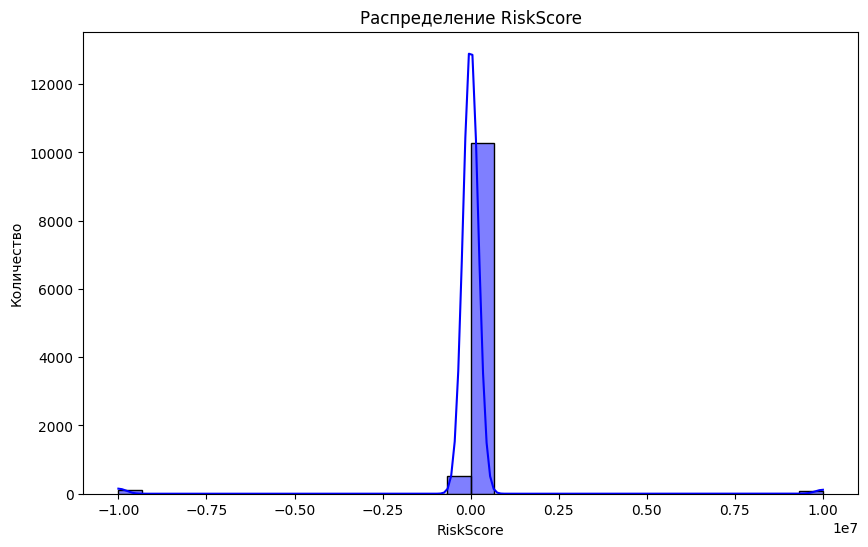

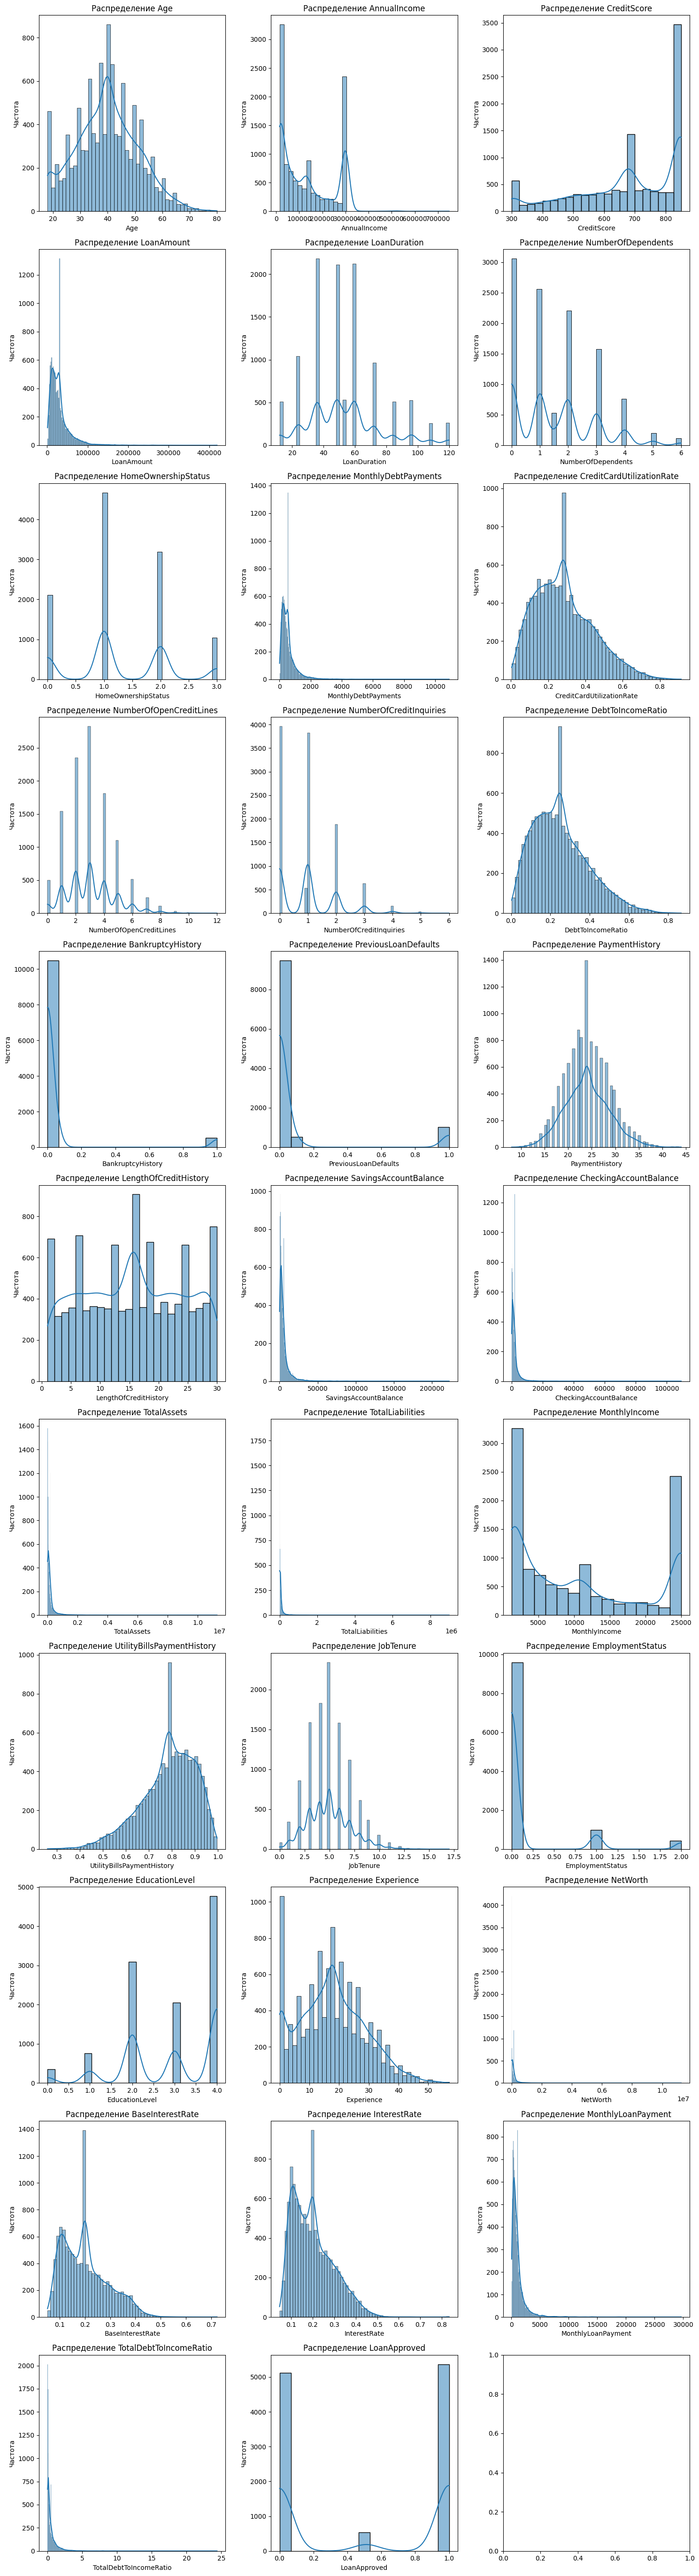

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filled['RiskScore'], bins=30, kde=True, color='blue')
plt.title('Распределение RiskScore')
plt.xlabel('RiskScore')
plt.ylabel('Количество')
plt.show()

numerical_features = df_filled.select_dtypes(include=['number']).columns
df_filled_copy = df_filled.copy().drop(columns=["RiskScore"])

n_rows = len(numerical_features) // 3 + (len(numerical_features) % 3 > 0)
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features.drop("RiskScore")):
    sns.histplot(df_filled_copy[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')

for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


удалим выбросы по квантили

In [ ]:
lower_bound = 0
upper_bound = df_filled['RiskScore'].quantile(0.99146)

df_filled = df_filled[(df_filled['RiskScore'] >= lower_bound) & (df_filled['RiskScore'] <= upper_bound)]



In [ ]:
df_filled['CreditScore_Log'] = np.log1p(df_filled['CreditScore'])
df_filled['CreditScore_Sqrt'] = np.sqrt(df_filled['CreditScore'])
df_filled['CreditScore_Cbrt'] = np.cbrt(df_filled['CreditScore'])
df_filled['CreditScore_sq2'] = df_filled['CreditScore'] ** 2
df_filled['CreditScore_sq3'] = df_filled['CreditScore'] ** 3

features = ["AnnualIncome", "MonthlyLoanPayment", "LoanAmount", 'NetWorth', "TotalAssets"]
for feature in features:
    df_filled[f'Log_{feature}'] = np.log1p(df_filled[feature])

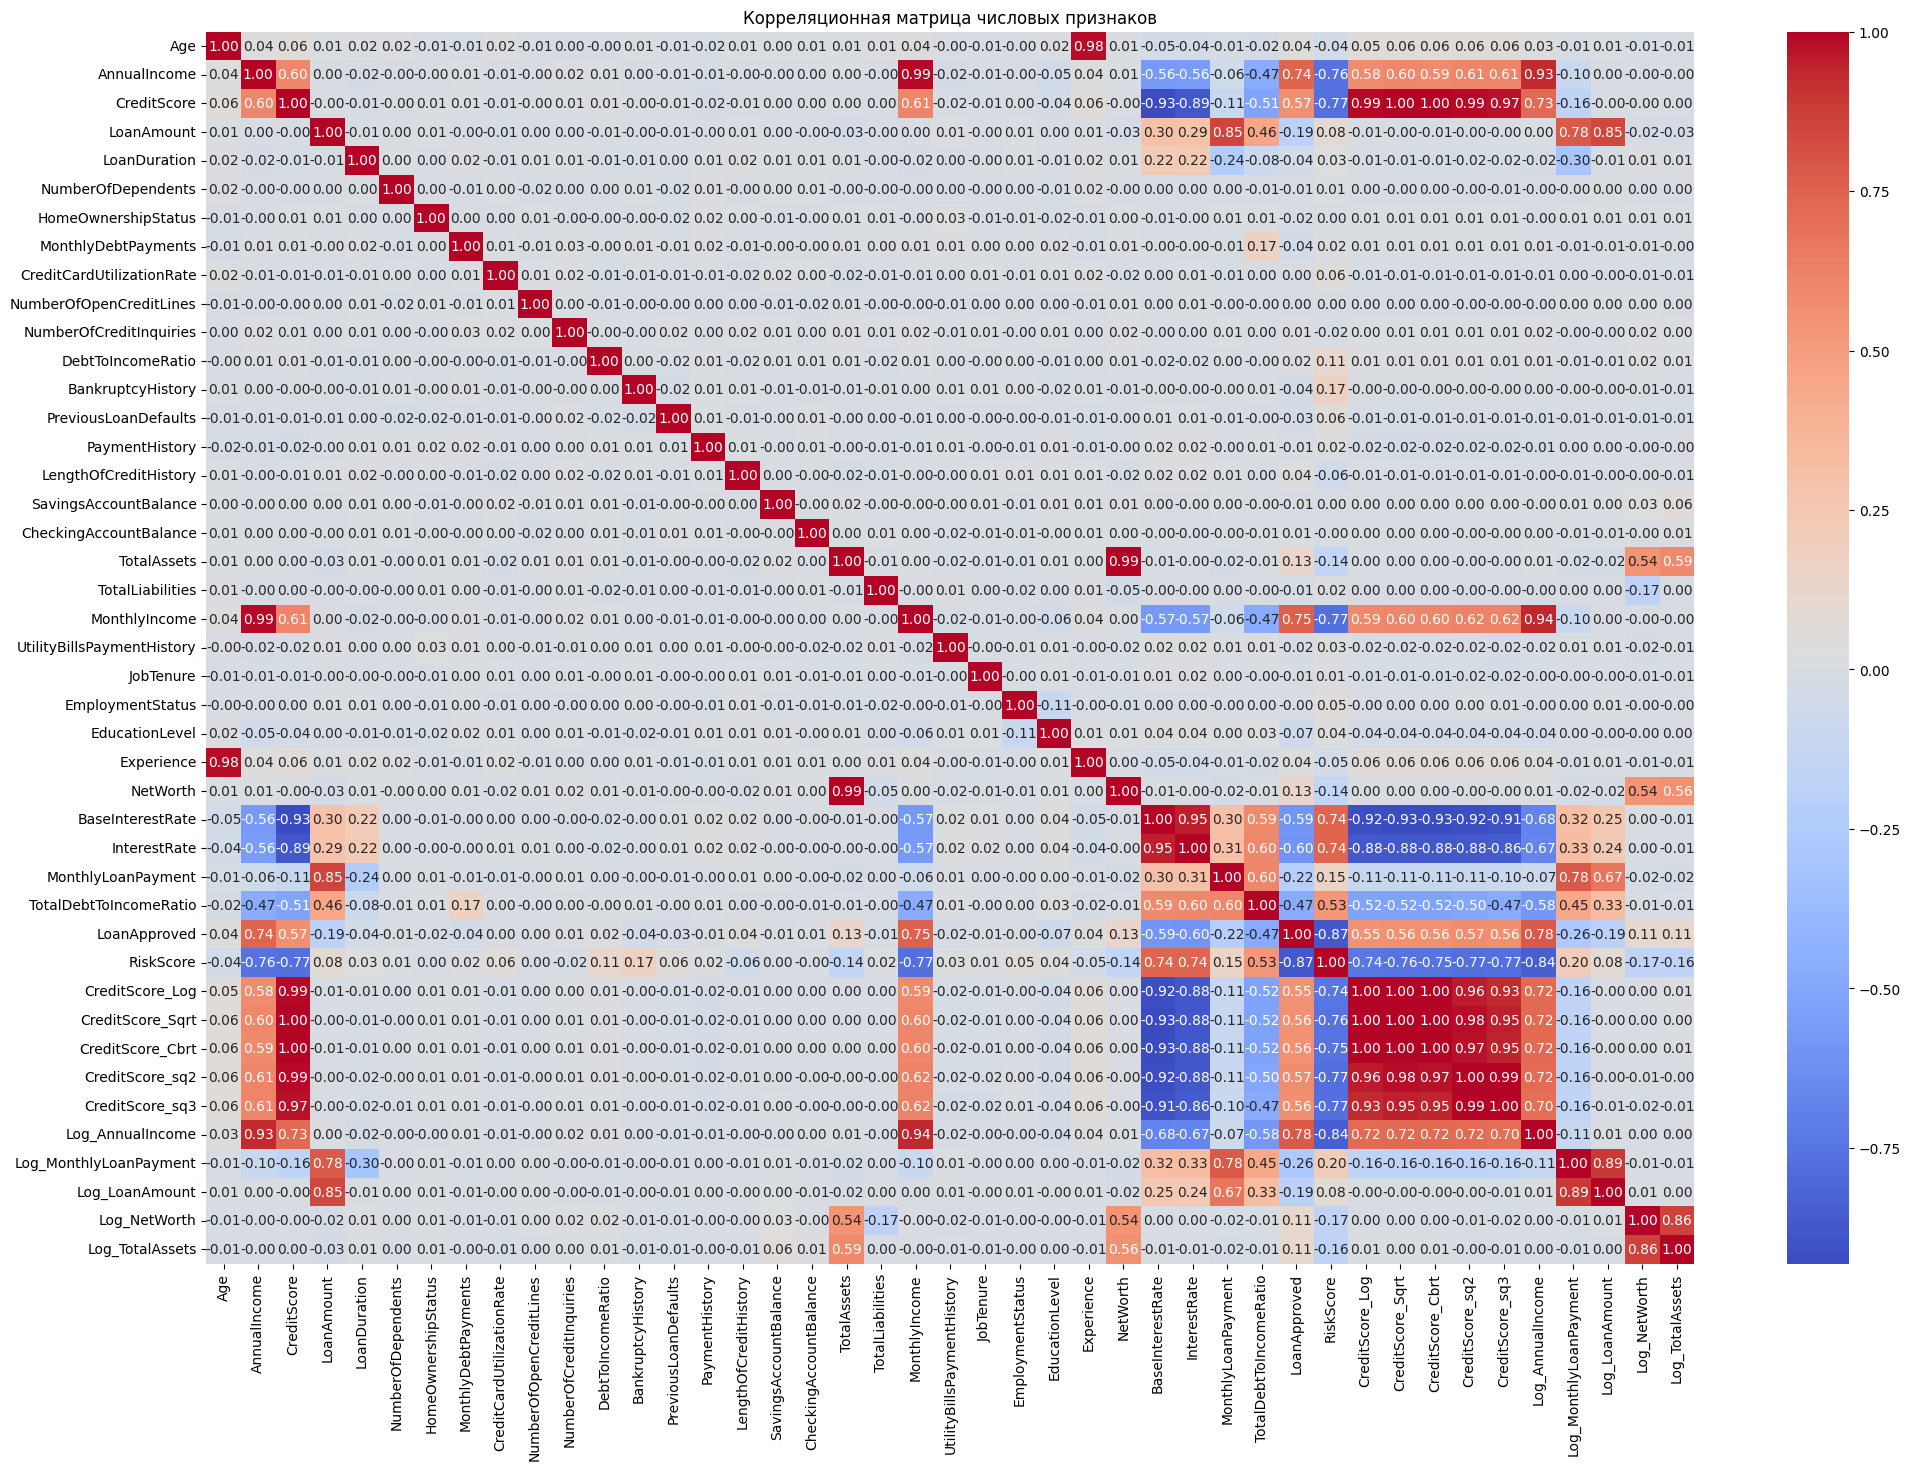

In [ ]:
correlation_matrix = df_filled.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица числовых признаков")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

df_n = df_filled.copy().select_dtypes("number")
features = df_n.drop(columns=["RiskScore"])
target = df_n["RiskScore"]
features_z = z_score_normalization(features)[0]
df_n_z = pd.DataFrame(features_z, columns=features.columns)
df_n_z["RiskScore"] = target

X = df_n_z.drop("RiskScore", axis=1).values
y = df_n_z["RiskScore"].values

In [ ]:
model1 = LinearRegressionModel()
model1.fit(X, y, method="analytical")
pred1 = model1.predict(X)
print("MSE (Analytical):", mse(y, pred1))

model2 = LinearRegressionModel()
model2.fit(X, y, method="gradient", learning_rate=0.01, epochs=1000)
pred2 = model2.predict(X)
print("MSE (Gradient):", mse(y, pred2))

model3 = LinearRegressionModel()
model3.fit(X, y, method="stochastic", learning_rate=0.001, epochs=300)
pred3 = model3.predict(X)
print("MSE (Stochastic):", mse(y, pred3))


model_sk1 = LinearRegression()
model_sk1.fit(X, y)
pred_sk1 = model_sk1.predict(X)
print("Sklearn MSE (Analytical):", mean_squared_error(y, pred_sk1))

model_sk2 = SGDRegressor(max_iter=1000, learning_rate='adaptive', eta0=0.01, random_state=42)
model_sk2.fit(X, y)
pred_sk2 = model_sk2.predict(X)
print("Sklearn MSE (Gradient):", mean_squared_error(y, pred_sk2))

model_sk3 = SGDRegressor(max_iter=300, learning_rate='adaptive', eta0=0.001, random_state=42)
model_sk3.fit(X, y)
pred_sk3 = model_sk3.predict(X)
print("Sklearn MSE (Stochastic):", mean_squared_error(y, pred_sk3))

print(f"{'Metric':<10}{'Custom':<15}{'Sklearn':<15}{'Difference':<15}")
print(f"{'MSE':<10}{mse(y, pred1):<15.4f}{mean_squared_error(y, pred1):<15.4f}{mse(y, pred1) - mean_squared_error(y, pred1):<15.4f}")
print(f"{'MAE':<10}{mae(y, pred1):<15.4f}{mean_absolute_error(y, pred1):<15.4f}{mae(y, pred1) - mean_absolute_error(y, pred1):<15.4f}")
print(f"{'MAPE':<10}{mape(y, pred1):<15.4f}{mean_absolute_percentage_error(y, pred1)*100:<15.4f}{mape(y, pred1) - mean_absolute_percentage_error(y, pred1)*100:<15.4f}")
print(f"{'R²':<10}{r2(y, pred1):<15.4f}{r2_score(y, pred1):<15.4f}{r2(y, pred1) - r2_score(y, pred1):<15.4f}")


MSE (Analytical): 12.568323317064047
MSE (Gradient): 15.2012976437541
MSE (Stochastic): 14.368944597003226
Sklearn MSE (Analytical): 12.567451499573377
Sklearn MSE (Gradient): 14.217841865030463
Sklearn MSE (Stochastic): 14.606721868366623
Metric    Custom         Sklearn        Difference     
MSE       12.5683        12.5683        0.0000         
MAE       2.7390         2.7390         0.0000         
MAPE      6.2663         6.2663         0.0000         
R²        0.9577         0.9577         0.0000         


# k-fold и leave-one-out



In [ ]:
def k_fold_cross_validation(X, y, model_class, k=5, method="analytical", **kwargs):
    n_samples = len(y)
    fold_size = n_samples // k
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    mse_scores = []

    for i in range(k):
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < k - 1 else n_samples

        test_idx = indices[test_start:test_end]
        train_idx = np.concatenate((indices[:test_start], indices[test_end:]))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = model_class()
        model.fit(X_train, y_train, method=method, **kwargs)
        y_pred = model.predict(X_test)

        mse_scores.append(mse(y_test, y_pred))

    return np.mean(mse_scores)


In [ ]:
mse_kfold = k_fold_cross_validation(X, y, LinearRegressionModel, k=5, method="analytical")
print(f"MSE (k-fold): {mse_kfold:.4f}")

MSE (k-fold): 12.6737


In [ ]:
def leave_one_out_cross_validation(X, y, model_class, method="analytical", **kwargs):
    n_samples = len(y)
    mse_scores = []

    for i in range(n_samples):
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        X_test = X[i].reshape(1, -1)
        y_test = y[i]

        model = model_class()
        model.fit(X_train, y_train, method=method, **kwargs)
        y_pred = model.predict(X_test)

        mse_scores.append((y_test - y_pred[0]) ** 2)

    return np.mean(mse_scores)


In [ ]:
mse_loocv = leave_one_out_cross_validation(X[:100], y[:100], LinearRegressionModel, method="analytical")
print(f"MSE (LOOCV, 100 obs): {mse_loocv:.4f}")


MSE (LOOCV, 100 obs): 24.7847


повторяем все с тестовым

In [ ]:
test = pd.read_csv("test.csv")
test_ids = test["ID"].copy()

home_ownership = {"Own": 0, "Mortgage": 1, "Rent": 2, "Other": 3}
employment_status = {"Employed": 0, "Self-Employed": 1, "Unemployed": 2}
education_level = {"Doctorate": 0, "Master": 1, "Bachelor": 2, "Associate": 3, "High School": 4}

pre_test = test.copy()
pre_test["HomeOwnershipStatus"] = pre_test["HomeOwnershipStatus"].map(home_ownership)
pre_test["EmploymentStatus"] = pre_test["EmploymentStatus"].map(employment_status)
pre_test["EducationLevel"] = pre_test["EducationLevel"].map(education_level)

df_test = pre_test.copy()
df_test['CreditScore_Log'] = np.log1p(df_test['CreditScore'])
df_test['CreditScore_Sqrt'] = np.sqrt(df_test['CreditScore'])
df_test['CreditScore_Cbrt'] = np.cbrt(df_test['CreditScore'])
df_test['CreditScore_sq2'] = df_test['CreditScore'] ** 2
df_test['CreditScore_sq3'] = df_test['CreditScore'] ** 3

for feature in ["AnnualIncome", "MonthlyLoanPayment", "LoanAmount", "NetWorth", "TotalAssets"]:
    df_test[f'Log_{feature}'] = np.log1p(df_test[feature])

df_test_n = df_test.select_dtypes("number").copy()
df_test_n_z = df_test_n.apply(lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1))

X_test = df_test_n_z.drop(columns=["ID"]).values

submission_df = pd.DataFrame({
    "ID": test_ids,
    "RiskScore": model1.predict(X_test)
})
submission_df.to_csv("submission.csv", index=False)
